# Samsung Capstone EDA

Needed Imports

In [99]:
%pip install pandas torch matplotlib seaborn category_encoders scikit-learn nltk > /dev/null 2>&1

import pandas as pd
import os
import re
import random
pd.set_option('display.max_columns', None)
import torch
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

# Ploting
import matplotlib.pyplot as plt
import seaborn as sns

# Encoders
from category_encoders import OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MinMaxScaler, LabelEncoder

# Supervised Learning
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier
from sklearn.svm import SVC

# Unsupervised Learning
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN, KMeans, AgglomerativeClustering

# Training Types and Metrics
from sklearn.model_selection import GridSearchCV, KFold, train_test_split
from sklearn.metrics import classification_report, f1_score, fbeta_score, make_scorer, ConfusionMatrixDisplay

#Ensemble
from sklearn.ensemble import RandomForestClassifier

# Stop Words
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer, WordNetLemmatizer
from nltk.tokenize import word_tokenize

lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words("english"))

Note: you may need to restart the kernel to use updated packages.


[nltk_data] Downloading package stopwords to
[nltk_data]     /home/mrduarte/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [100]:
# Some functions
def cleaner(text):
    text = re.sub('[.*?]|\w*\d\w*|\n|https?:\\\S+|www\.\S+|<.*?>+', ' ', text)
    #text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\\W', " ", text)
    return text

def standardize_data(sentence,stopwords):
    treated_tokens=[]
    #convert lower case
    sentence_lower=sentence.lower()
    #tokenize
    word_tokens = word_tokenize(sentence_lower)
    #remove stop words
    #standardize words using stemming or lematization
    for word in word_tokens:
        if word not in stopwords:
            word = lemmatizer.lemmatize(word, pos="v")
            treated_tokens.append(word)
    
    # join all the treated tokens again 
    return ' '.join(treated_tokens)

def label_bar_chart(
    input_df: pd.DataFrame, 
    title: str, 
    label: str = None, 
    labels: list = None, 
    colors: list = None,
    normalize_value: bool = True,
    percent_label: bool = False
) -> None:
        
    # computes frequencies of labels and converts to percentages
    label_frequencies = input_df[label].value_counts(normalize=normalize_value)
    
    # Multiply the pertenges x100 and reindex based on lables list
    label_frequencies = label_frequencies.apply(lambda x: x * 100)
    label_frequencies = label_frequencies.reindex(index = labels[::-1])

    # Generate randorm colors:
    if colors is None:
        colors = [
            f"#{random.randint(0, 0xFFFFFF):06x}" for labels in labels
        ]
    
    # creates a horizontal bar chart with a descriptive title
    axis = label_frequencies.plot(kind='barh', figsize=(12, 8), color=colors)
    axis.set_title(f"Distribution of {label} values ({title}, sample_size={len(input_df)})", size=20)

    # add percentages
    if percent_label is True:
        axis.bar_label(axis.containers[0], labels=[f'{v:.2f}%' for v in label_frequencies.values], padding=5)


<>:3: SyntaxWarning: invalid escape sequence '\w'
<>:3: SyntaxWarning: invalid escape sequence '\w'
/tmp/ipykernel_630620/268425951.py:3: SyntaxWarning: invalid escape sequence '\w'
  text = re.sub('[.*?]|\w*\d\w*|\n|https?:\\\S+|www\.\S+|<.*?>+', ' ', text)


## Politifact Fact Check

In [ ]:
# Load datataset Politifact Fact Check Dataset
## Repo Link
#politifact=pd.read_csv('https://raw.githubusercontent.com/JaimeFerreira2002/Truthify/refs/heads/main/Datasets/politifact_factcheck_data.json')
## Locally/Codespaces
politifact=pd.read_json(os.path.join('Datasets','politifact_factcheck_data.json'), lines=True)

# Clean the dataset statement text and remove stop_words
#politifact['statement']=politifact['statement'].apply(cleaner)
politifact.insert(
    politifact.columns.get_loc('statement') + 1,
    'statement_no_stopwords',
    politifact['statement'].apply(lambda x: standardize_data(cleaner(x), stop_words))
)

# Convert datetime to data type
politifact['statement_date'] = pd.to_datetime(politifact['statement_date'])
politifact['factcheck_date'] = pd.to_datetime(politifact['factcheck_date'])

politifact.head(5)
politifact.info()

#No null values
#print("Null values:")
#politifact.isnull().sum()

def print_one_row_politifact(index: int) -> None:
    """Relevant collum for analysis"""
    print(f"speaker: {politifact.iat[index, 1]}")
    print(f"statement: {politifact.iat[index, 2]}")
    print(f"source: {politifact.iat[index, 4]}")
    print(f"label: {politifact.iat[index, 0]}")

,verdict,statement_originator,statement,statement_no_stopwords,statement_date,statement_source,factchecker,factcheck_date,factcheck_analysis_link
0,true,Barack Obama,John McCain opposed bankruptcy protections for...,john mccain oppose bankruptcy protections fami...,2008-06-11,speech,Adriel Bettelheim,2008-06-16,https://www.politifact.com/factchecks/2008/jun...
1,false,Matt Gaetz,"""Bennie Thompson actively cheer-led riots in t...",bennie thompson actively cheer lead riot,2022-06-07,television,Yacob Reyes,2022-06-13,https://www.politifact.com/factchecks/2022/jun...
2,mostly-true,Kelly Ayotte,"Says Maggie Hassan was ""out of state on 30 day...",say maggie hassan state days last three months,2016-05-18,news,Clay Wirestone,2016-05-27,https://www.politifact.com/factchecks/2016/may...
3,false,Bloggers,"""BUSTED: CDC Inflated COVID Numbers, Accused o...",bust cdc inflate covid number accuse violate f...,2021-02-01,blog,Madison Czopek,2021-02-05,https://www.politifact.com/factchecks/2021/feb...
4,half-true,Bobby Jindal,"""I'm the only (Republican) candidate that has ...",republican candidate actually reduce size gove...,2015-08-30,television,Linda Qiu,2015-08-30,https://www.politifact.com/factchecks/2015/aug...


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21152 entries, 0 to 21151
Data columns (total 9 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   verdict                  21152 non-null  object        
 1   statement_originator     21152 non-null  object        
 2   statement                21152 non-null  object        
 3   statement_no_stopwords   21152 non-null  object        
 4   statement_date           21152 non-null  datetime64[ns]
 5   statement_source         21152 non-null  object        
 6   factchecker              21152 non-null  object        
 7   factcheck_date           21152 non-null  datetime64[ns]
 8   factcheck_analysis_link  21152 non-null  object        
dtypes: datetime64[ns](2), object(7)
memory usage: 1.5+ MB
Null values:


verdict                    0
statement_originator       0
statement                  0
statement_no_stopwords     0
statement_date             0
statement_source           0
factchecker                0
factcheck_date             0
factcheck_analysis_link    0
dtype: int64

## Veridict Analysis

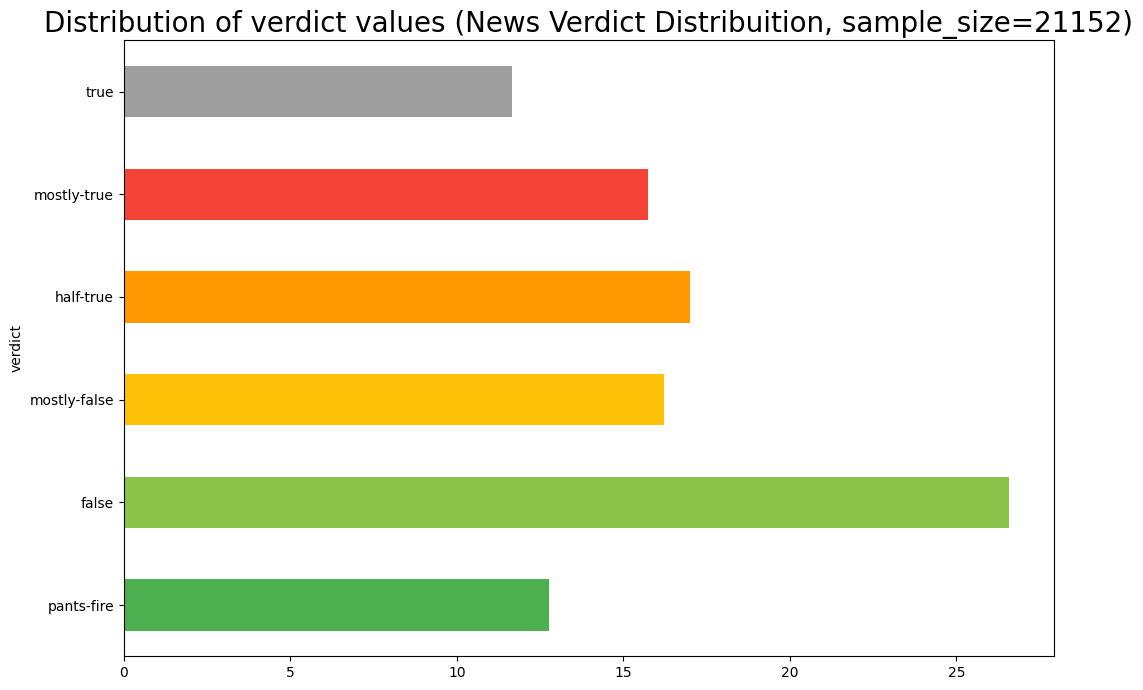

In [102]:
#politifact.verdict.value_counts()
labels = ['true', 'mostly-true', 'half-true', 'mostly-false','false', 'pants-fire']
colors = [
    "#4CAF50",  # True - Green
    "#8BC34A",  # Mostly True - Light Green
    "#FFC107",  # Half True - Yellow
    "#FF9800",  # Mostly False - Orange
    "#F44336",  # False - Red
    "#9E9E9E",  # Pants Fire - Gray
]

label_bar_chart(politifact, "News Verdict Distribuition", "verdict", labels, colors, percent_label=False)

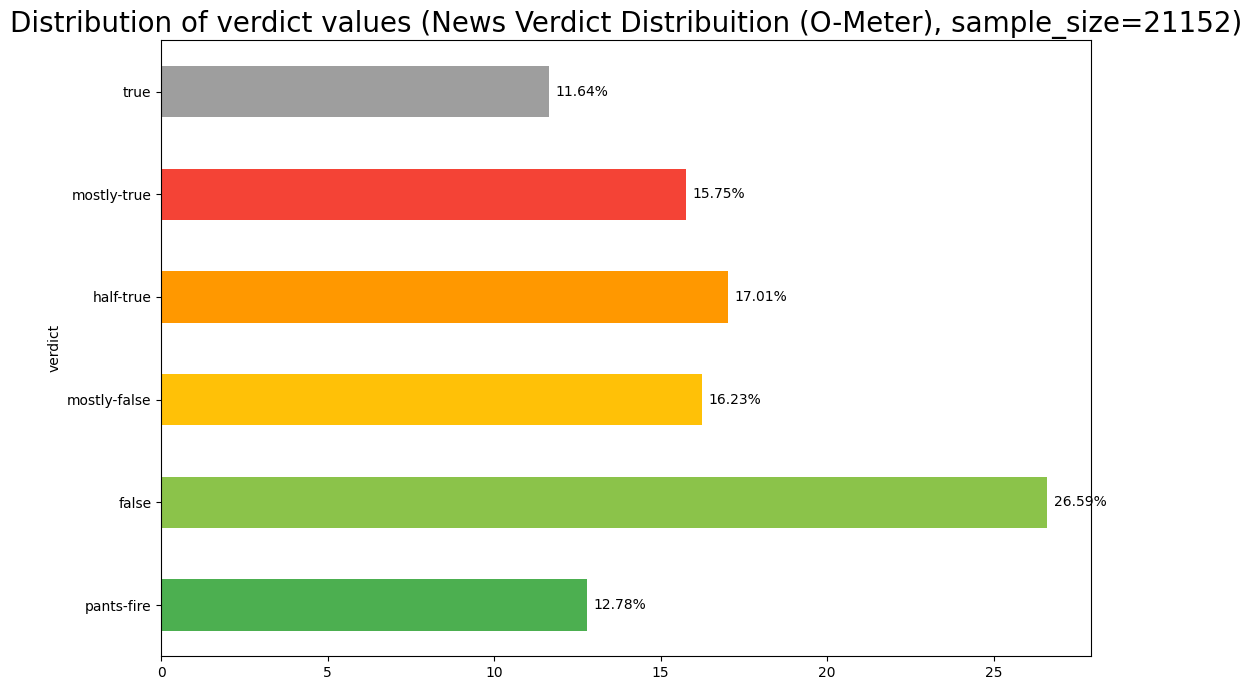

In [103]:
labels = ['true', 'mostly-true', 'half-true', 'mostly-false','false', 'pants-fire']
colors = [
    "#4CAF50",  # True - Green
    "#8BC34A",  # Mostly True - Light Green
    "#FFC107",  # Half True - Yellow
    "#FF9800",  # Mostly False - Orange
    "#F44336",  # False - Red
    "#9E9E9E",  # Pants Fire - Gray
]

label_bar_chart(politifact, "News Verdict Distribuition (O-Meter)", "verdict", labels, colors, percent_label=True)

## Statement Analysis

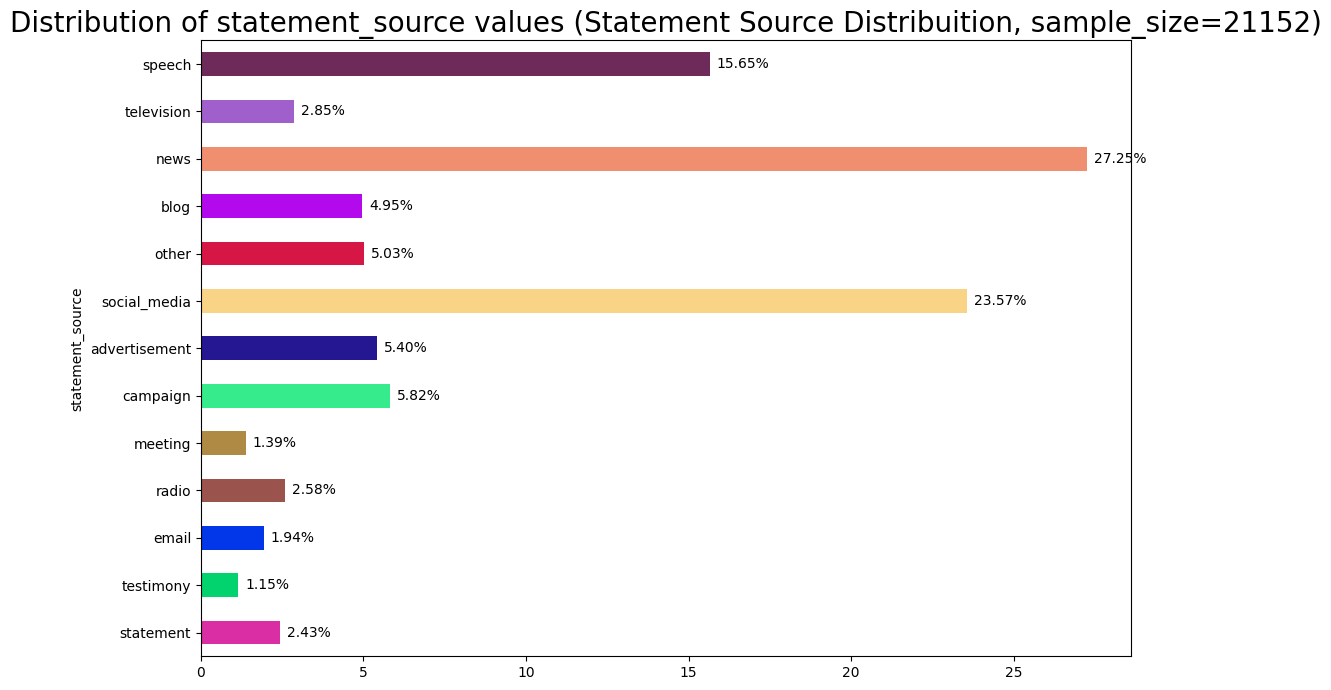

In [104]:
labels = politifact.statement_source.unique().tolist()
label_bar_chart(politifact, "Statement Source Distribuition", "statement_source", labels, percent_label=True)

We can see the lengh of statements

<Figure size 1200x800 with 0 Axes>

ValueError: No objects to concatenate

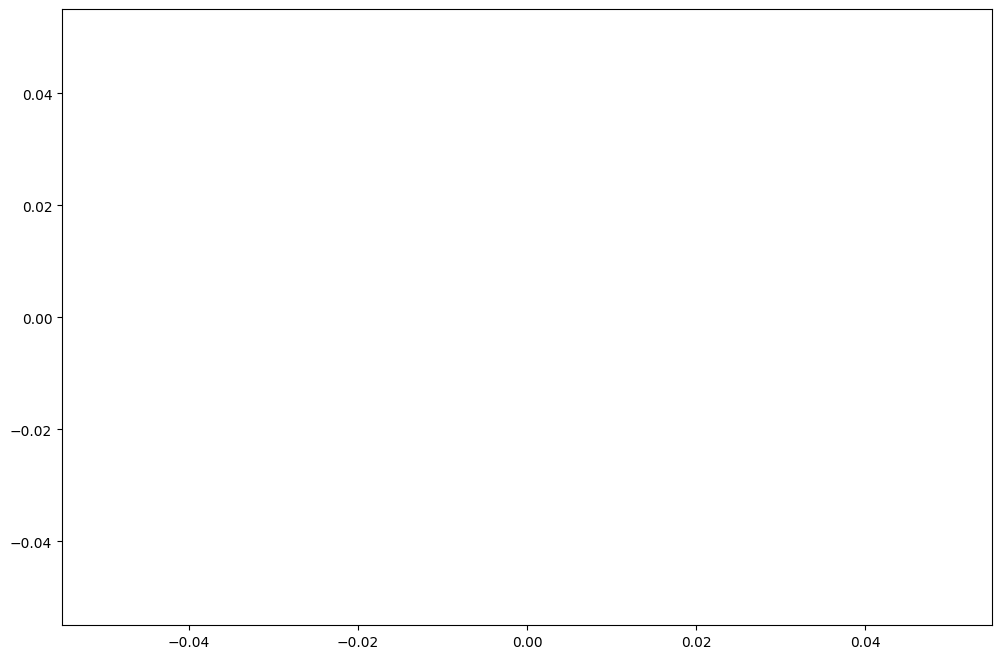

In [105]:
# Statement length
if 'statement_length' not in politifact.columns:
    politifact.insert(
        politifact.columns.get_loc('statement_no_stopwords') + 1,
        'statement_length',
        politifact['statement'].apply(lambda x: x.split())
    )

# Plot histogram
plt.figure(figsize=(12, 8))
sns.histplot(politifact['statement_length'], kde=False, bins=30)
plt.title('Distribution of Statement Lengths')
plt.xlabel('Statement Length (words)')
plt.ylabel('Number of Statements')
#plt.bar_label(plt.gca().patches, labels=[f'{int(height.get_height())}' for height in plt.gca().patches], padding=3)
plt.show()

## Speaker anaysis
Check the number of existing speaker to check if the dataset is to narrow or not, and avarege statement made by each

In [82]:
unique_speaker=politifact['statement_originator'].nunique()
avg_statement_per_speaker=len(politifact)/unique_speaker

print(f'Unique speaker in dataset: {unique_speaker}')
print(f'Average statement per speaker: {avg_statement_per_speaker:.2f}')

Unique speaker in dataset: 4565
Average statement per speaker: 4.63


We can also make a bar plot that give true-meter for each speaker

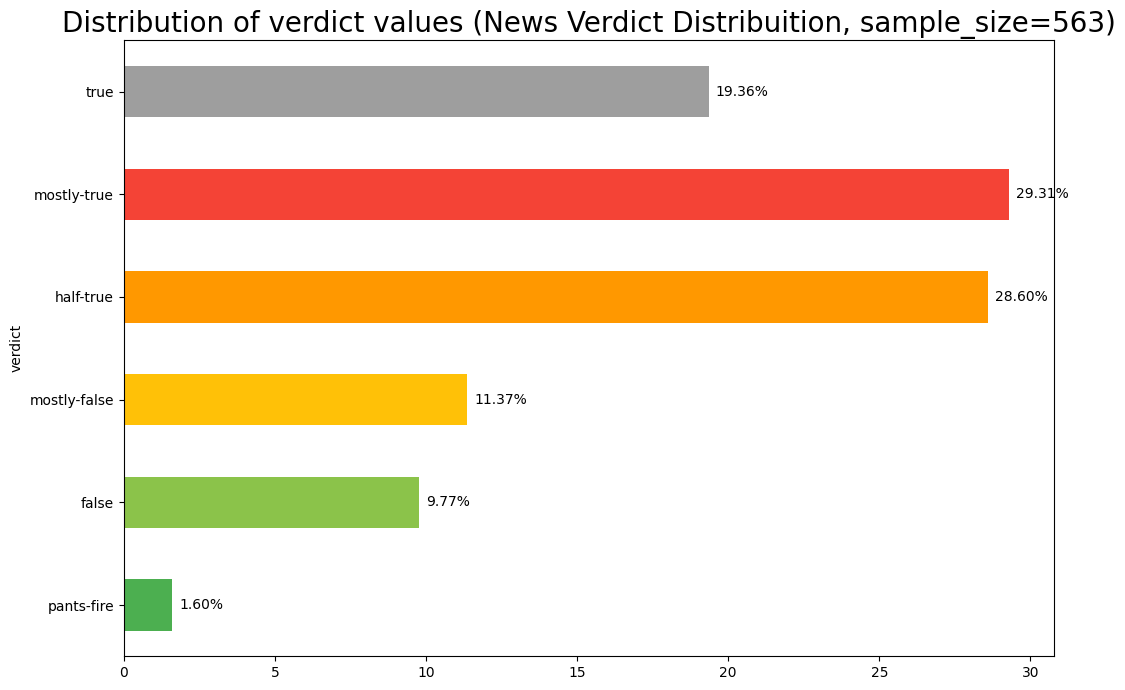

In [83]:
def label_bar_chart_per_speaker(speaker: str, labels: list = None, colors: list = None):
    if labels is None and colors is None:
        labels = ['true', 'mostly-true', 'half-true', 'mostly-false','false', 'pants-fire']
        colors = [
            "#4CAF50",  # True - Green
            "#8BC34A",  # Mostly True - Light Green
            "#FFC107",  # Half True - Yellow
            "#FF9800",  # Mostly False - Orange
            "#F44336",  # False - Red
            "#9E9E9E",  # Pants Fire - Gray
        ]

    speaker_filter=(politifact["statement_originator"] == speaker)
    speaker_polifact = politifact[speaker_filter]

    label_bar_chart(speaker_polifact, "News Verdict Distribuition", "verdict", labels, colors, percent_label=True)

label_bar_chart_per_speaker("Barack Obama")

We can also represent true or false only:

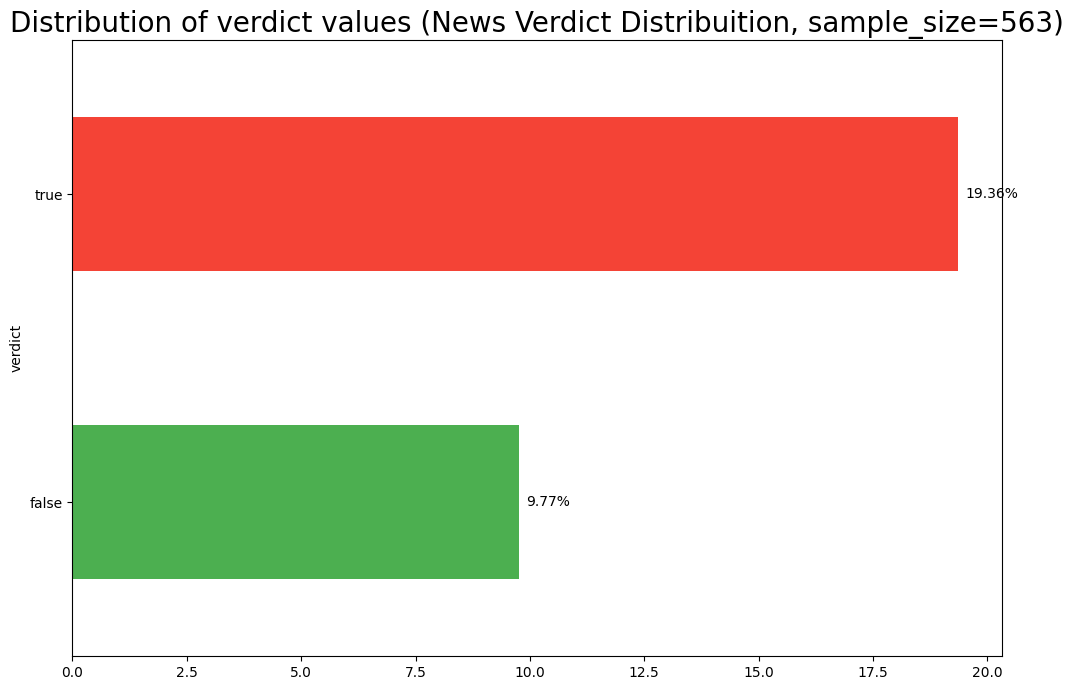

In [ ]:
labels = ['true','false']
colors = [
    "#4CAF50",  # True - Green
    "#F44336",  # False - Red
]
label_bar_chart_per_speaker("Barack Obama", labels, colors)

## Snopes Fact-news Data

In [85]:
# Load datataset Snopes Fact-news Data
## Repo Link
#snopes=pd.read_csv('https://raw.githubusercontent.com/JaimeFerreira2002/Truthify/refs/heads/main/Datasets/snopeswithsum.csv')
## Locally/Codespaces
snopes=pd.read_csv(os.path.join('Datasets','snopeswithsum.csv'))

#print("Null values:")
#snopes.isnull().sum()

# Clean the dataset text
snopes.insert(
    snopes.columns.get_loc('question') + 1,
    'question_no_stopwords',
    snopes['question'].apply(lambda x: standardize_data(cleaner(x), stop_words)))

snopes.insert(
    snopes.columns.get_loc('comment') + 1,
    'comment_no_stopwords',
    snopes['comment'].apply(lambda x: standardize_data(cleaner(x), stop_words))
)
snopes.insert(
    snopes.columns.get_loc('claim') + 1,
    'claim_no_stopwords',
    snopes['claim'].apply(lambda x: standardize_data(cleaner(x), stop_words))
)
snopes.insert(
    snopes.columns.get_loc('summary') + 1,
    'summary_no_stopwords',
    snopes['summary'].apply(lambda x: standardize_data(cleaner(x), stop_words))
)

## Fill nan with empty string
snopes["what's true"]=snopes["what's true"].fillna("")
snopes["what's false"]=snopes["what's false"].fillna("")
snopes["what's unknown"]=snopes["what's unknown"].fillna("")

snopes.head(5)
snopes.info()

def print_one_row_snopes(index: int) -> None:
    """Relevant collum for analysis"""
    print(f"question: {snopes.iat[index, 0]}")
    print(f"comment: {snopes.iat[index, 1]}")
    print(f"claim: {snopes.iat[index, 2]}")
    print(f"origin: {snopes.iat[index, 4]}")
    print(f"label: {snopes.iat[index, 7]}")

,question,question_no_stopwords,comment,comment_no_stopwords,claim,claim_no_stopwords,rate,what's true,what's false,what's unknown,origin,summary,summary_no_stopwords
0,Did Kamala Harris Support Abortion Until the T...,kamala harris support abortion time give birth,The Democratic vice-presidential candidate's p...,democratic vice presidential candidate pro abo...,"U.S. Sen. Kamala Harris, D-Calif., supports th...",u sen kamala harris calif support ability carr...,Mixture,"U.S. Sen. Kamala Harris, D-Calif, has maintain...",She has not explicitly stated that she support...,,Debates surrounding abortion frequently resurf...,"U.S. Sen. Kamala Harris, D-Calif., has been to...",u sen kamala harris calif tout pro abortion ri...
1,Did Hitler Invent the Inflatable Sex Doll?,hitler invent inflatable sex doll,Nothing attracts curiosity like a lurid combin...,nothing attract curiosity like lurid combinati...,Adolf Hitler was behind the invention of the f...,adolf hitler behind invention first inflatable...,False,,,,"In late July 2020, readers shared a 2016 blog ...",Readers shared a 2016 blog post with the headl...,readers share blog post headline adolf hitler ...
2,Does Texting ‘RBG’ to 50409 Send a Letter to Y...,texting rbg send letter senators,The automated political advocacy service Resis...,automate political advocacy service resistbot ...,"Texting ""RBG"" to 50409 engages a service calle...",texting rbg engage service call resistbot gene...,True,,,,"In September 2020, following the death of U.S....",Readers asked Snopes to examine the accuracy a...,readers ask snopes examine accuracy authentici...
3,Pride Parade Fire Hydrant Mishap,pride parade fire hydrant mishap,An image depicts a man stabbed at an altercati...,image depict man stab altercation kkk members ...,An image depicts an overenthusiastic Pride att...,image depict overenthusiastic pride attendee i...,Miscaptioned,,,,Yearly Pride festivities were marked on 26 Jun...,A Twitter user tweeted a photograph of a blood...,twitter user tweet photograph bloody fire hydr...
4,Swedish Police Hand Out ‘Don’t Touch Me’ Brace...,swedish police hand touch bracelets stop refug...,Police in Sweden have introduced sexual assaul...,police sweden introduce sexual assault awarene...,Swedish police have introduced anti-sexual ass...,swedish police introduce anti sexual assault b...,Mixture,Police in Sweden are distributing colored brac...,Swedish police did not create or distribute th...,,"On 30 June 2016, the Federalist Papers web sit...",Police in Sweden have come up with a sure-fire...,police sweden come sure fire way stop middle e...


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4550 entries, 0 to 4549
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   question               4550 non-null   object
 1   question_no_stopwords  4550 non-null   object
 2   comment                4550 non-null   object
 3   comment_no_stopwords   4550 non-null   object
 4   claim                  4550 non-null   object
 5   claim_no_stopwords     4550 non-null   object
 6   rate                   4550 non-null   object
 7   what's true            4550 non-null   object
 8   what's false           4550 non-null   object
 9   what's unknown         4550 non-null   object
 10  origin                 4550 non-null   object
 11  summary                4550 non-null   object
 12  summary_no_stopwords   4550 non-null   object
dtypes: object(13)
memory usage: 462.2+ KB


rate
False                   2288
True                     548
Mixture                  498
Unproven                 307
Mostly False             266
Labeled Satire           161
Miscaptioned             153
Mostly True              103
Correct Attribution       80
Scam                      38
Misattributed             38
Outdated                  37
Legend                    31
Lost Legend                1
Research In Progress       1
Name: count, dtype: int64

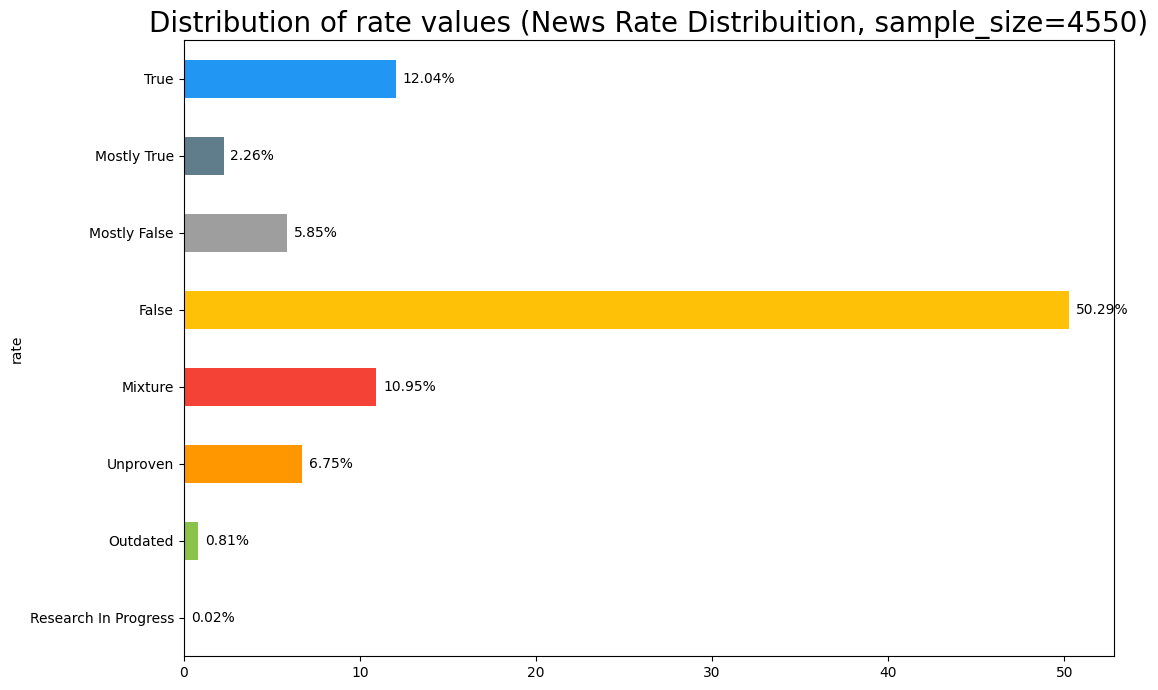

In [86]:
snopes.rate.value_counts()
# Some of the rates were drop this ones are the most important
labels = ['True', 'Mostly True', 'Mostly False','False', 'Mixture', 'Unproven', 'Outdated', 'Research In Progress']
colors = [
    "#4CAF50",  # True - Green
    "#8BC34A",  # Mostly True - Light Green
    "#FF9800",  # Mostly False - Orange
    "#F44336",  # False - Red
    "#FFC107",  # Mixture - Yellow
    "#9E9E9E",  # Unproven - Gray
    "#607D8B",  # Outdated - Blue Gray
    "#2196F3"   # Research In Progress - Blue
]

label_bar_chart(snopes, "News Rate Distribuition", "rate", labels, colors, percent_label=True)

## Fake News Classification

In [87]:
# Load datataset Fake News Classification
## Repo Link
#news_article=pd.read_csv('https://raw.githubusercontent.com/JaimeFerreira2002/Truthify/refs/heads/main/Datasets/news_articles.csv')
## Locally/Codespaces
news_article=pd.read_csv(os.path.join('Datasets','news_articles.csv'))

news_article.head(5)
news_article.info()
print("Null values:")
news_article.isnull().sum()
# drop all object type (strings), and check for any negative value
print("Negative values:")
(news_article.select_dtypes(exclude=['object']) < 0).sum()

,author,published,title,text,language,site_url,main_img_url,type,label,title_without_stopwords,text_without_stopwords,hasImage
0,Barracuda Brigade,2016-10-26T21:41:00.000+03:00,muslims busted they stole millions in govt ben...,print they should pay all the back all the mon...,english,100percentfedup.com,http://bb4sp.com/wp-content/uploads/2016/10/Fu...,bias,Real,muslims busted stole millions govt benefits,print pay back money plus interest entire fami...,1.0
1,reasoning with facts,2016-10-29T08:47:11.259+03:00,re why did attorney general loretta lynch plea...,why did attorney general loretta lynch plead t...,english,100percentfedup.com,http://bb4sp.com/wp-content/uploads/2016/10/Fu...,bias,Real,attorney general loretta lynch plead fifth,attorney general loretta lynch plead fifth bar...,1.0
2,Barracuda Brigade,2016-10-31T01:41:49.479+02:00,breaking weiner cooperating with fbi on hillar...,red state \nfox news sunday reported this mor...,english,100percentfedup.com,http://bb4sp.com/wp-content/uploads/2016/10/Fu...,bias,Real,breaking weiner cooperating fbi hillary email ...,red state fox news sunday reported morning ant...,1.0
3,Fed Up,2016-11-01T05:22:00.000+02:00,pin drop speech by father of daughter kidnappe...,email kayla mueller was a prisoner and torture...,english,100percentfedup.com,http://100percentfedup.com/wp-content/uploads/...,bias,Real,pin drop speech father daughter kidnapped kill...,email kayla mueller prisoner tortured isis cha...,1.0
4,Fed Up,2016-11-01T21:56:00.000+02:00,fantastic trumps point plan to reform healthc...,email healthcare reform to make america great ...,english,100percentfedup.com,http://100percentfedup.com/wp-content/uploads/...,bias,Real,fantastic trumps point plan reform healthcare ...,email healthcare reform make america great sin...,1.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2096 entries, 0 to 2095
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   author                   2096 non-null   object 
 1   published                2096 non-null   object 
 2   title                    2096 non-null   object 
 3   text                     2050 non-null   object 
 4   language                 2095 non-null   object 
 5   site_url                 2095 non-null   object 
 6   main_img_url             2095 non-null   object 
 7   type                     2095 non-null   object 
 8   label                    2095 non-null   object 
 9   title_without_stopwords  2094 non-null   object 
 10  text_without_stopwords   2046 non-null   object 
 11  hasImage                 2095 non-null   float64
dtypes: float64(1), object(11)
memory usage: 196.6+ KB
Null values:


author                      0
published                   0
title                       0
text                       46
language                    1
site_url                    1
main_img_url                1
type                        1
label                       1
title_without_stopwords     2
text_without_stopwords     50
hasImage                    1
dtype: int64

Negative values:


hasImage    0
dtype: int64